In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.7 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
from ultralytics import YOLO

face_detector = YOLO("/content/drive/MyDrive/Colab Notebooks/yolov8n-face.pt")


## Processing for single image

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/prathamesh.png")

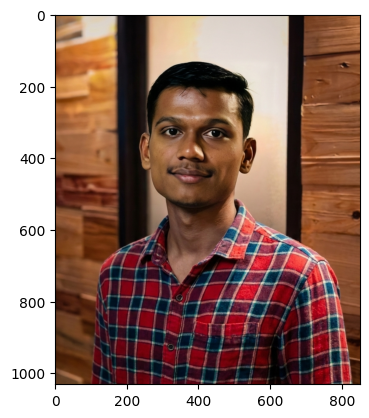

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
results = face_detector.predict(img)


0: 640x544 1 face, 182.1ms
Speed: 6.1ms preprocess, 182.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


In [ ]:
results[0].boxes.xyxy[0].cpu().numpy().astype(int)

array([264, 208, 521, 531])

In [ ]:
x1, y1, x2, y2=results[0].boxes.xyxy[0].cpu().numpy().astype(int)

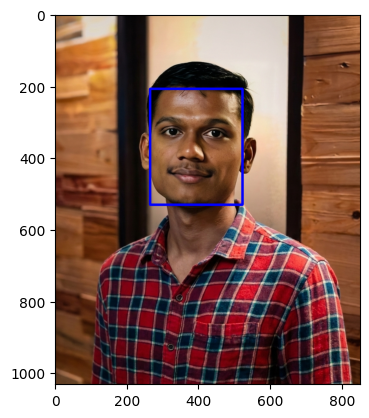

In [ ]:
img = cv2.rectangle(img, (x1, y1),(x2, y2),(0, 0, 255), 5)
plt.imshow(img)

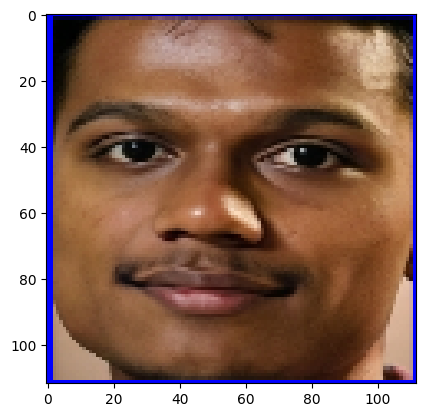

In [ ]:
my_face = img[y1:y2, x1:x2]
#Facenet takes as input 160x160
my_face = cv2.resize(my_face, (112,112))
plt.imshow(my_face)

## Images before processing

In [ ]:
plot_images_from_folders("/content/drive/MyDrive/face-detect")


Output hidden; open in https://colab.research.google.com to view.

# Automate the preprocessing


In [ ]:
class FACELOADING:
    def __init__(self, directory, detector):
        self.directory = directory
        self.target_size = (112, 112)
        self.X = []
        self.Y = []
        self.detector = detector

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.target_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def extract_face(self, filename):
        img = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = self.detector(img_rgb, verbose=False)

        if len(results[0].boxes) == 0:
            return None

        box = results[0].boxes.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = box

        face = img_rgb[y1:y2, x1:x2]

        face_arr = cv2.resize(face, self.target_size)
        return face_arr

    def load_faces(self, directory_path):
        FACES = []
        for im_name in os.listdir(directory_path):
            path = os.path.join(directory_path, im_name)
            single_face = self.extract_face(path)
            if single_face is not None:
                FACES.append(single_face)
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            if not os.path.isdir(path):
                continue

            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]

            print(f"Loaded successfully: {len(labels)} faces from {sub_dir}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        n_images = len(self.X)
        ncols = 6
        nrows = (n_images + ncols - 1) // ncols

        plt.figure(figsize=(6 * ncols-6, 6 * nrows-6))

        for num, image in enumerate(self.X):
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis("off")

        plt.tight_layout()
        plt.show()



In [ ]:
faceloading = FACELOADING("/content/drive/MyDrive/face-detect", face_detector)
X, Y = faceloading.load_classes()


Loaded successfully: 0 faces from .ipynb_checkpoints
Loaded successfully: 8 faces from Bunty
Loaded successfully: 8 faces from Iswar


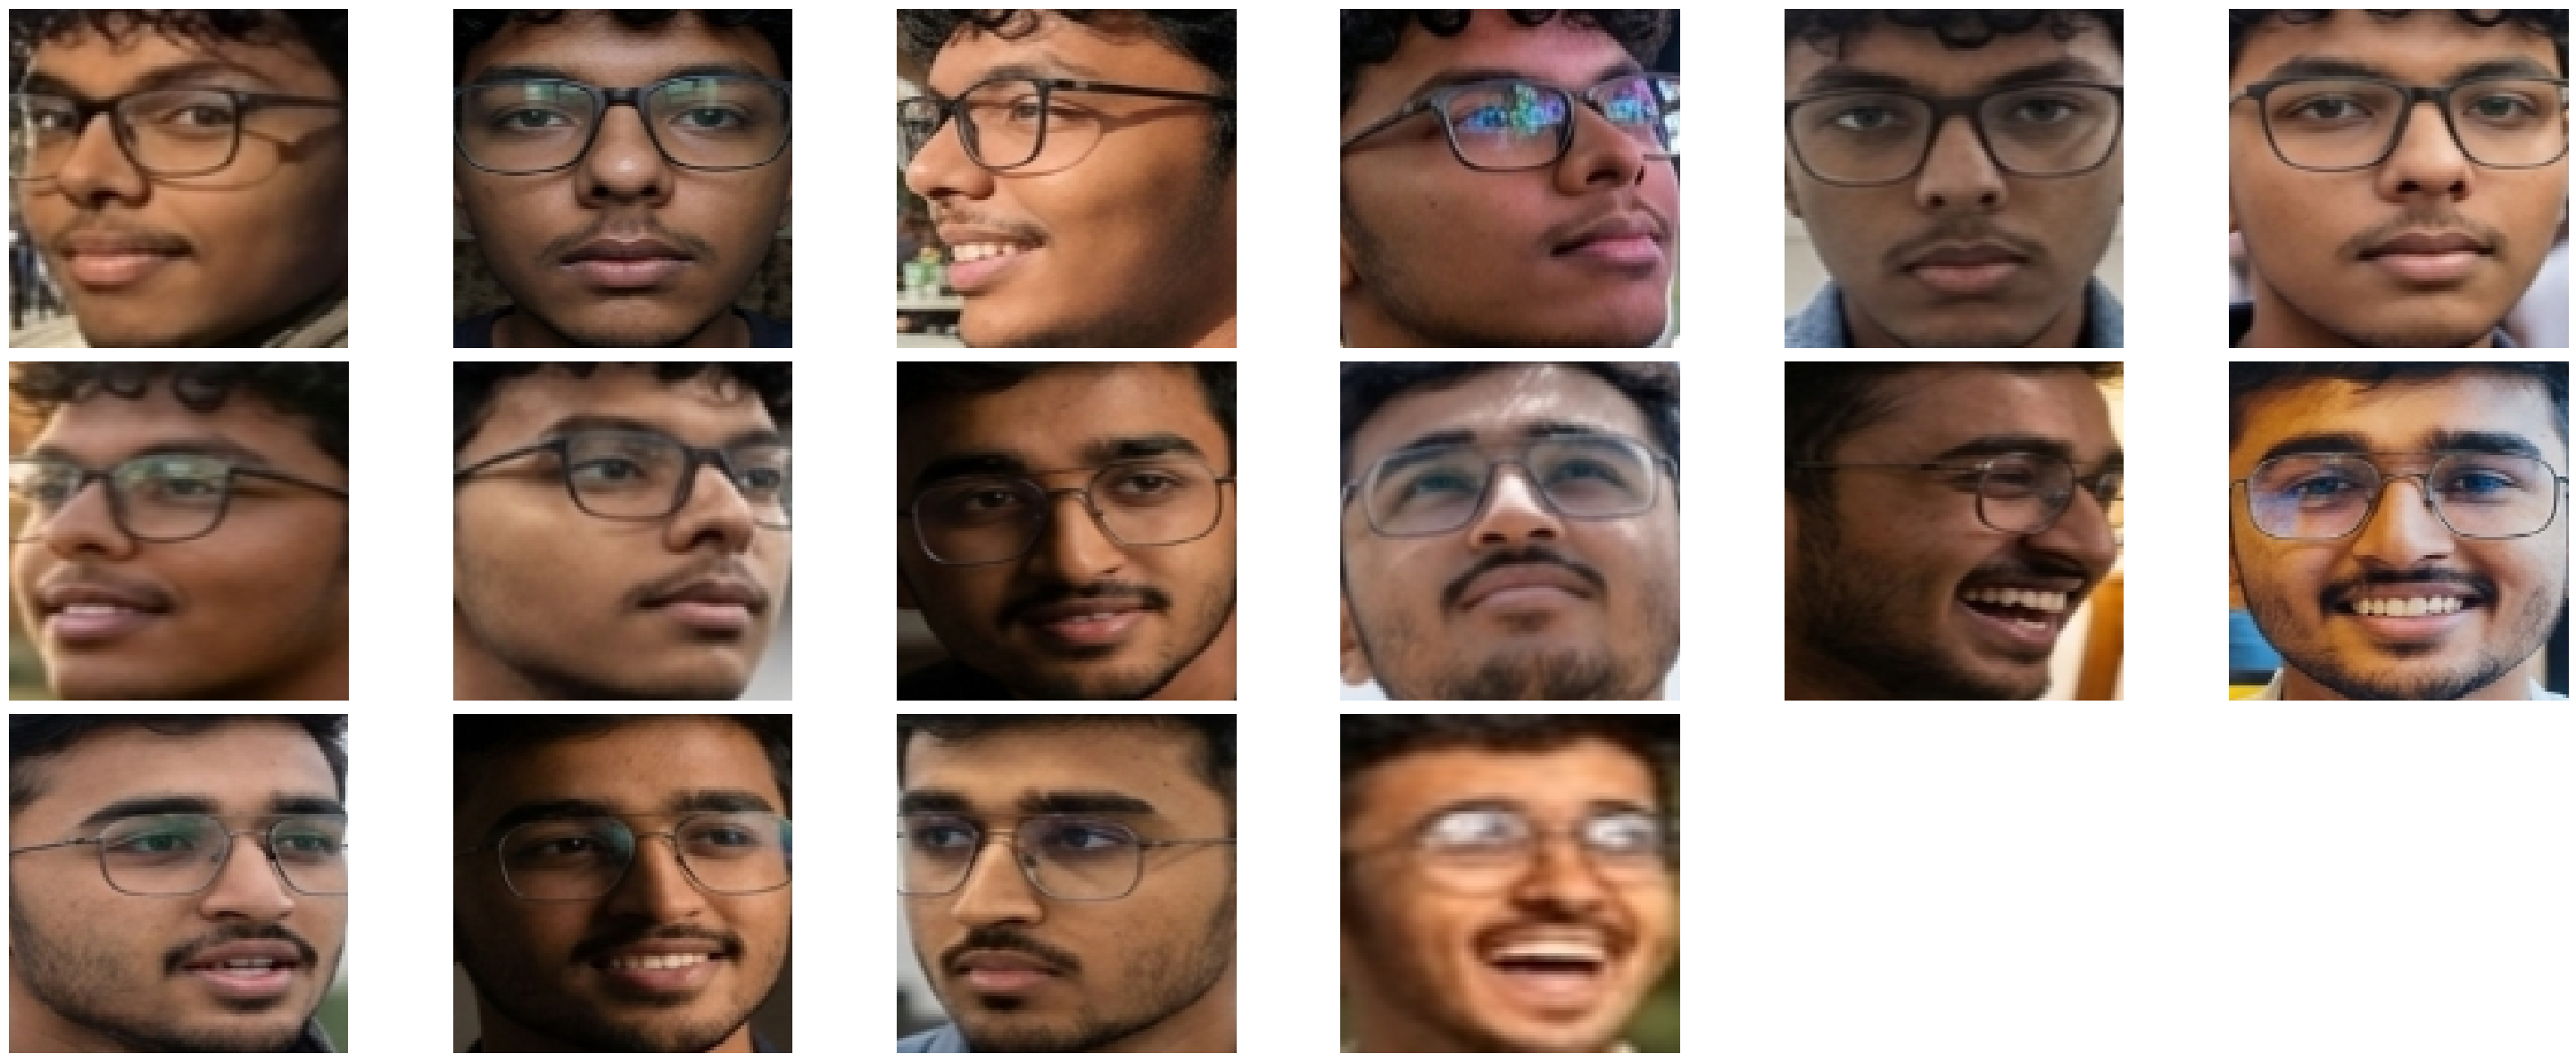

In [ ]:
faceloading.plot_images()

## ArcFace part for Embedding

In [ ]:
!pip install -U insightface onnxruntime opencv-python


In [ ]:
from insightface.app import FaceAnalysis

app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:04<00:00, 62922.77KB/s]
/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:
arcface = app.models['recognition']

In [ ]:
def get_arcface_embedding(img_input):
    if isinstance(img_input, str):
        img = cv2.imread(img_input)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif isinstance(img_input, np.ndarray):
        img = img_input
    else:
        return None

        img = cv2.resize(img, (112, 112))

    # get Feature Embedding
    embedding = arcface.get_feat(img)
    # Flatten and Normalize
    embedding = embedding.flatten()
    norm = np.linalg.norm(embedding)

    embedding_norm = embedding / norm

    return embedding_norm

In [ ]:
EMBEDDED_X = []

for img in X:   # X: numpy array or list of RGB face crops
    try:
        emb = get_arcface_embedding(img)
        EMBEDDED_X.append(emb)
    except Exception as e:
        print(" Embedding failed:", e)

In [ ]:
EMBEDDED_X = np.asarray(EMBEDDED_X)
Y = np.asarray(Y)

print("Embeddings shape:", EMBEDDED_X.shape)
print("Labels shape:", Y.shape)

Embeddings shape: (16, 512)
Labels shape: (16,)


In [ ]:
np.savez_compressed(
    "faces_embeddings_arcface.npz",
    EMBEDDED_X=EMBEDDED_X,
    Y=Y
)

## Inference Pipeline(Cosine Similarity)

In [ ]:
import numpy as np

data = np.load("faces_embeddings_arcface.npz", allow_pickle=True)

DB_EMB = data["EMBEDDED_X"]
DB_LABELS = data["Y"]


In [ ]:
DB_EMB = DB_EMB / np.linalg.norm(DB_EMB, axis=1, keepdims=True)


In [ ]:
def recognize_face(query_emb, db_emb, db_labels, threshold=0.4):
    if query_emb is None:
        return "No Face Feature", 0.0

    # Cosine Similarity check
    sims = np.dot(db_emb, query_emb)
    # best match
    best_idx = np.argmax(sims)
    best_score = sims[best_idx]

    if best_score >= threshold:
        return str(db_labels[best_idx]), float(best_score)
    else:
        return "Unknown", float(best_score)

In [ ]:
#1. Load image, 2. Detects faces using YOLO, 3. Recognizes faces using ArcFace, 4. Draws bounding boxes and labels.
def process_and_recognize_image(image_source, detector, db_embeddings, db_labels, threshold=0.38):
    if isinstance(image_source, str):
        image = cv2.imread(image_source)
    else:
        image = image_source.copy()

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    results = detector(image_rgb, verbose=False)[0]
    # process Detections
    for box in results.boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        face_crop_rgb = image_rgb[y1:y2, x1:x2]
        # get embedding
        query_emb = get_arcface_embedding(face_crop_rgb)
        # recognize
        name, score = recognize_face(query_emb, db_embeddings, db_labels, threshold)
        # draw Visuals
        color = (0, 255, 0) if name != "Unknown" else (0, 0, 255)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        label_text = f"{name} ({score:.2f})"
        (t_w, t_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(image, (x1, y1 - 25), (x1 + t_w, y1), color, -1)
        cv2.putText(image, label_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    return image

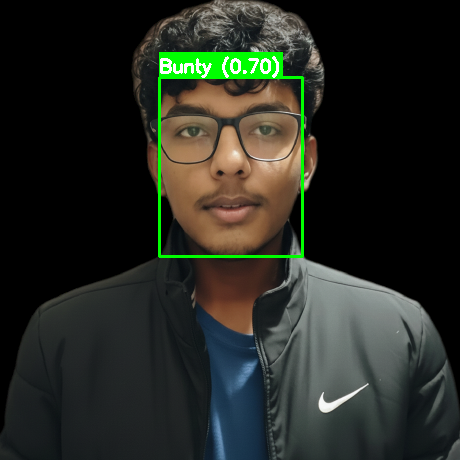

In [ ]:
result_img = process_and_recognize_image("/content/drive/MyDrive/Colab Notebooks/bunty-test.png", face_detector, DB_EMB, DB_LABELS, threshold=0.30)
cv2_imshow(result_img)

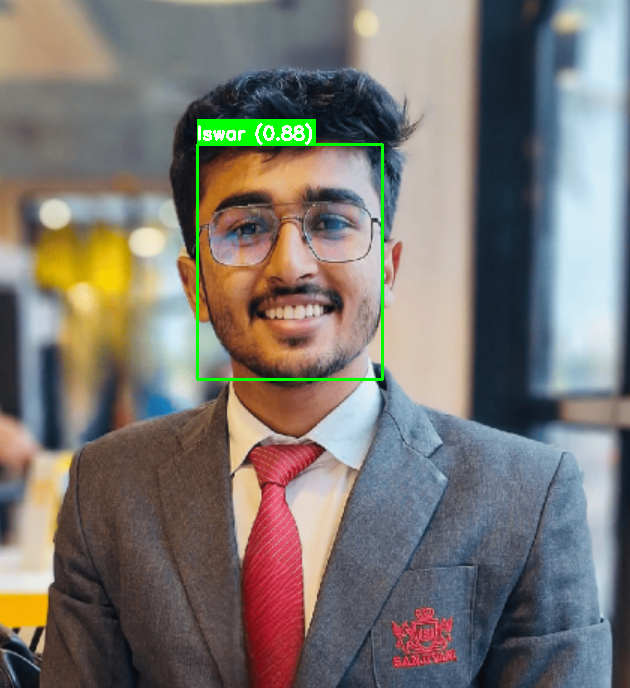

In [ ]:
result_img = process_and_recognize_image("/content/drive/MyDrive/Colab Notebooks/iswar-test.png", face_detector, DB_EMB, DB_LABELS, threshold=0.30)
cv2_imshow(result_img)

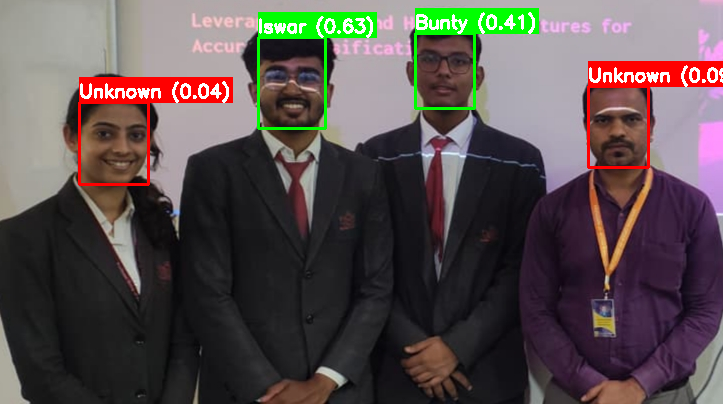

In [ ]:
result_img = process_and_recognize_image("/content/drive/MyDrive/Colab Notebooks/grp-test2.jpg", face_detector, DB_EMB, DB_LABELS, threshold=0.30)
cv2_imshow(result_img)

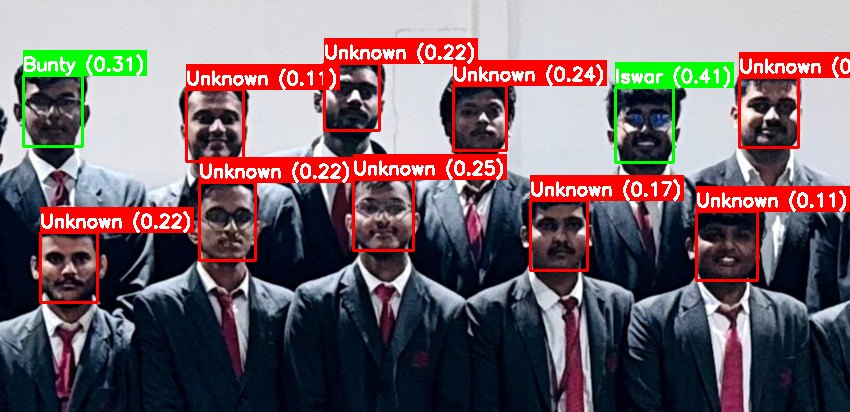

In [ ]:
result_img = process_and_recognize_image("/content/drive/MyDrive/Colab Notebooks/grp-test1.JPG", face_detector, DB_EMB, DB_LABELS, threshold=0.30)
cv2_imshow(result_img)